In [7]:
# # Installing missing libraries
# !conda install -c conda-forge fiona --yes ;
# !conda install -c conda-forge utm --yes;
# !conda install -c conda-forge googlemaps --yes;
# !conda install -c conda-forge geopy --yes;

import os
import sys


# add funciotns directory to system path
module_path = os.path.abspath(os.path.join('/home/gremlin/GGCW_tools_git/Functions')) 
if module_path not in sys.path:
    sys.path.append(module_path)

sys.path

['',
 '/anaconda/lib/python27.zip',
 '/anaconda/lib/python2.7',
 '/anaconda/lib/python2.7/plat-linux2',
 '/anaconda/lib/python2.7/lib-tk',
 '/anaconda/lib/python2.7/lib-old',
 '/anaconda/lib/python2.7/lib-dynload',
 '/anaconda/lib/python2.7/site-packages',
 '/anaconda/lib/python2.7/site-packages/IPython/extensions',
 '/home/gremlin/.ipython',
 '/home/gremlin/GGCW_tools_git/Functions']

In [8]:
### home made functions
import nice_functions as nf

reload(nf)

import get_OSM_polygons as getOSM

reload(getOSM)

### other libraries
from collections import namedtuple

import pandas as pd
import numpy as np

from shapely.ops import transform
from shapely.geometry import mapping, Polygon, box, shape
import matplotlib.pyplot as plt

from matplotlib import pyplot
%matplotlib inline

import random

import fiona

import pickle

from gbdxtools import Interface
from gbdxtools.task import env
from gbdxtools import CatalogImage

gbdx = Interface()

In [9]:
# function for calculating overlap 
def area_overlap(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy 

In [11]:
bbox_city = nf.get_city_bounding_box('amsterdam')


epsg = nf.get_projections_and_UTM(bbox_city)

In [16]:
multipolygon_type = pickle.load(open( "../Pickle/multipolygon_type.p", "rb" ))

bbox_wkt = box(*bbox_city).wkt

In [21]:
query = "(item_type:WV03_VNIR OR WV02)"
query += " AND NOT item_type:IDAHOImage AND item_type:DigitalGlobeProduct"   
results = gbdx.vectors.query(bbox_wkt, query,count = 1e5)

In [18]:
query = "(item_type:)" 
results = gbdx.vectors.query(bbox_wkt, query,count = 1e5)

In [19]:
results

[{u'geometry': {u'coordinates': [[[[6.071679540593987, 53.24020834570321],
      [6.071679540593987, 52.222566040961574],
      [4.498460539188841, 52.222566040961574],
      [4.498460539188841, 53.24020834570321],
      [6.071679540593987, 53.24020834570321]]]],
   u'type': u'MultiPolygon'},
  u'properties': {u'attributes': {u'bandsList': [u'CoastalAerosol',
     u'Blue',
     u'Green',
     u'Red',
     u'VegRedEdge5',
     u'VegRedEdge6',
     u'VegRedEdge7',
     u'NIR',
     u'VegRedEdge8a',
     u'WaterVapor',
     u'Cirrus',
     u'SWIR11',
     u'SWIR12'],
    u'browseJpgFile': u'preview.jpg',
    u'bucketName': u'sentinel-s2-l1c',
    u'bucketPrefix': u'tiles/31/U/FU/2018/1/9/1',
    u'catalogID': u'S2B_OPER_MSI_L1C_DS_MTI__20180109T114957_S20180109T110422_N02.06',
    u'cloudCover_int': 100,
    u'gridSquare': u'FU',
    u'imageFile': u'preview.jpg',
    u'latitudeBand': u'U',
    u'offNadirAngle_dbl': 11.091211820593285,
    u'part_int': 0,
    u'platformName': u'SENTINEL2',

In [22]:

# query images that cover the park
# query = "(item_type:WV03_VNIR OR WV02 OR QB02 OR GE01)"


# calculate the overlap between image and park

Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

ra = Rectangle(bbox_city[0],bbox_city[1],bbox_city[2],bbox_city[3]) # set wgs park area in rectangle

total_area = ((ra.xmax-ra.xmin)*(ra.ymax-ra.ymin))



# create dataframe for image metadata
images_df = pd.DataFrame(columns=['id','month','year','type','resolution','cloud cover','overlap','check'])

i = 1

# loop over all found images and load metadata in dataframe
# also perform a test to find the right images
for r in results:
    props = r['properties']
    geom = r['geometry']

    coordinates_image = geom['coordinates'][0][0]
    df_overlap = pd.DataFrame.from_records(coordinates_image,columns = ['x','y'])

    rb = Rectangle(df_overlap.x.min(), df_overlap.y.min(), df_overlap.x.max(), df_overlap.y.max())



    total_overlap = area_overlap(ra, rb)

    if total_overlap is None:
        fraction_overlap = 0
    else:
        fraction_overlap = total_overlap/total_area
      
  

    images_df = images_df.append({'id': props['attributes']['catalogID'],'month':props['item_date'][5:7],'year':props['item_date'][0:4],
                   'type':props['item_type'][1],'resolution':props['attributes']['resolution_dbl'],
                   'cloud cover':props['attributes']['cloudCover_int'],'overlap': fraction_overlap,
                    # perform check on, cloud cover, month (summer), and overlap 
                    'check':props['attributes']['cloudCover_int'] < 10 and int(props['item_date'][5:7]) >= 5 and int(props['item_date'][5:7]) <= 11 and 
                   fraction_overlap >.05},ignore_index=True)


# select only the images that survive the test
selection_images = images_df.reset_index().loc[images_df.check == True]

# group by image id because 
selection_images =  selection_images.groupby(['id'],sort=['year','month'],as_index=False).first().sort_values(['year','month'], ascending=False).reset_index().drop('level_0', axis='columns')



In [23]:
selection_images


,id,index,month,year,type,resolution,cloud cover,overlap,check
0,103001006FD63D00,130,08,2017,WV02,2.277,5,0.089104,True
1,103001006D79BB00,101,07,2017,WV02,1.896,3,0.214433,True
2,1040010030B00E00,75,07,2017,WV03_VNIR,1.304,2,0.418828,True
3,104001002BC52E00,227,05,2017,WV03_VNIR,1.544,0,0.350534,True
4,103001005EA2BC00,232,09,2016,WV02,2.055,0,0.123086,True
5,103005004DF8CF00,113,05,2016,WV02,0.636,0,0.303847,True
6,103005004DF97900,17,05,2016,WV02,0.476,0,0.150906,True
7,1030050045F94600,18,10,2015,WV02,2.482,0,0.754107,True
8,1030050045F94700,29,10,2015,WV02,0.658,0,0.154618,True
9,1040010013A34500,31,10,2015,WV03_VNIR,1.416,5,0.161332,True


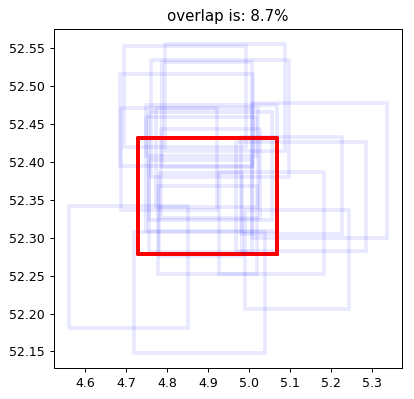

In [24]:
all_coords_df = pd.DataFrame(columns = ['x','y','i'])

for i in selection_images['index']:

    coordinates_image = results[i]['geometry']['coordinates'][0][0]

    df_overlap = pd.DataFrame.from_records(coordinates_image,columns = ['x','y'])
    
    df_overlap['i'] = i
    
    all_coords_df = all_coords_df.append(df_overlap)
    
    rb = Rectangle(df_overlap.x.min(), df_overlap.y.min(), df_overlap.x.max(), df_overlap.y.max())
    
    
    x,y = box(bbox_city[0],bbox_city[1],bbox_city[2],bbox_city[3]).exterior.xy
        

    x1,y1 = box(df_overlap.x.min(), df_overlap.y.min(), df_overlap.x.max(), df_overlap.y.max()).exterior.xy



    total_area = ((ra.xmax-ra.xmin)*(ra.ymax-ra.ymin))




    # calculate the overlap between image and park

    Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

    ra = Rectangle(bbox_city[0],bbox_city[1],bbox_city[2],bbox_city[3])

    rb = Rectangle(min(x1),min(y1),max(x1),max(y1))



    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    ax.plot(x, y, color = 'red', alpha=0.2,
        linewidth=3, solid_capstyle='round', zorder=2)

    ax.plot(x1,y1, color='blue', alpha=0.09,
        linewidth=3, solid_capstyle='round', zorder=2)

    # ax.set_xlim([4.6, 5.2])
    # ax.set_ylim([52.2, 52.5])


    ax.plot()
    ax.set_title('overlap is: {}%'.format( str(round(area_overlap(a=ra,b=rb)/total_area,3)*100)))

In [25]:
all_coords_df

,x,y,i
0,4.794300,52.530959,130
1,5.088431,52.555681,130
2,5.088192,52.439353,130
3,4.794658,52.414267,130
4,4.794300,52.530959,130
0,4.979921,52.432772,101
1,5.226750,52.433099,101
2,5.226508,52.305434,101
3,4.980145,52.305228,101
4,4.979921,52.432772,101


In [14]:

#create function for rewrite 

base_coords_x = min(np.concatenate([x,all_coords_df['x']])) 
base_coords_y = min(np.concatenate([y,all_coords_df['y']])) 

    


x_n = np.subtract(x, base_coords_x)
y_n = np.subtract(y, base_coords_y)





for i in np.unique(all_coords_df['i']):
    
    all_coords_df['x_n'] =   all_coords_df['x'] - base_coords_x
    all_coords_df['y_n'] =   all_coords_df['y'] - base_coords_y 
    
    
width  = int(max(np.concatenate([x_n,all_coords_df['x_n']])) * 1000)
height = int(max(np.concatenate([y_n,all_coords_df['y_n']])) * 1000)



In [15]:
def image_draw_thing(all_coords_df,subset,nr):

        x_min_2 = all_coords_df['x_n'][all_coords_df['i'] == subset[nr]].min()
        y_min_2 = all_coords_df['y_n'][all_coords_df['i'] == subset[nr]].min()
        x_max_2 = all_coords_df['x_n'][all_coords_df['i'] == subset[nr]].max()
        y_max_2 = all_coords_df['y_n'][all_coords_df['i'] == subset[nr]].max()

        x2,y2 = box(x_min_2, y_min_2, x_max_2, y_max_2).exterior.xy

        polygon2 = [(x2[i_1]*1000, y2[i_1]*1000) for i_1 in range(len(x2))]

        img2 = Image.new('L', (width, height), 0)

        ImageDraw.Draw(img2).polygon(polygon2, fill=1)
        
        b = np.asarray(img2)
        
        return b

In [ ]:
from PIL import Image, ImageDraw
import copy

import time
start_time = time.time()



import itertools

i = 0

stuff = selection_images['index']
for L in range(1, 4 if len(stuff) > 4 else len(stuff)):
    for subset in itertools.combinations(stuff, L):
        
        

        polygon = [(x_n[i_1]*1000, y_n[i_1]*1000) for i_1 in range(len(x_n))]

        
        b = image_draw_thing(all_coords_df,subset,0)
        



        if L >= 2: 
            
            b1 = image_draw_thing(all_coords_df,subset,1)
                    
        if L >= 3: 
            
            b2 = image_draw_thing(all_coords_df,subset,2)
                        
        if L >= 4: 
            
            b3 = image_draw_thing(all_coords_df,subset,3)
            
            

        # convert polygon coordinates to raster/array values using ImageDraw
        img = Image.new('L', (width, height), 0)

        ImageDraw.Draw(img).polygon(polygon, fill=1)

        a = np.asarray(img)

        
        
        if L == 1:
            c = a+b
        elif L == 2:
            c = a+b+b1
        elif L == 3:
            c = a+b+b1+b2
        elif L == 4:
            c = a+b+b1+b2+b3
            
        
        
        total_overlap_perc = round(sum(sum((a == 1) & (c > 1)))/float(sum(sum((a == 1)))),3) *100
        
        total_double_overlap = round(sum(sum((a == 1) & (c > 2)))/float(sum(sum((a == 1)))),3) *100
        
        
#         print(str(total_overlap_perc) + '% total overlap ' + str(total_double_overlap) + '% double overlap, subset is: '+ str(subset))
#         print("--- %s seconds --- \r" % (time.time() - start_time))
        
        
        if (total_overlap_perc > 10) & (total_double_overlap < 10):

            fig = plt.figure(i, figsize=(5,5), dpi=90)
            ax = fig.add_subplot(111)

            ax.imshow(c)

            ax.set_title(str(subset) +' overlap is: ' + str(total_overlap_perc) + '% double overlap is: ' + str(total_double_overlap))

            plt.gca().invert_yaxis()

    #         print(str(L) + str(subset) +' overlap is: ' + str(total_overlap_perc) + '%')

        i = i + 1 

# test cells

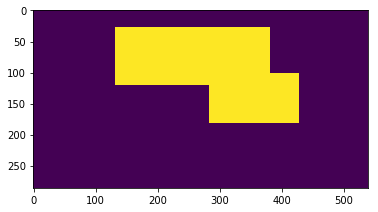

In [150]:
plt.imshow((a == 1)& (c > 1))


In [148]:
round(sum(sum((a == 1) & (c >= 1)))/float(width * height),5)

0.33966

In [139]:
sum(sum((a == 1) & (c >= 1)))/float(width * height)



0.33966033966033965

In [138]:
float(width * height)

154154.0

In [51]:


stuff = selection_images['index']
for L in range(1, 5 if len(stuff) > 5 else len(stuff)):
  for subset in itertools.combinations(stuff, L):
    print(subset)

(37,)
(49,)
(98,)
(58,)
(69,)
(68,)
(72,)
(66,)
(76,)
(85,)
(37, 49)
(37, 98)
(37, 58)
(37, 69)
(37, 68)
(37, 72)
(37, 66)
(37, 76)
(37, 85)
(49, 98)
(49, 58)
(49, 69)
(49, 68)
(49, 72)
(49, 66)
(49, 76)
(49, 85)
(98, 58)
(98, 69)
(98, 68)
(98, 72)
(98, 66)
(98, 76)
(98, 85)
(58, 69)
(58, 68)
(58, 72)
(58, 66)
(58, 76)
(58, 85)
(69, 68)
(69, 72)
(69, 66)
(69, 76)
(69, 85)
(68, 72)
(68, 66)
(68, 76)
(68, 85)
(72, 66)
(72, 76)
(72, 85)
(66, 76)
(66, 85)
(76, 85)
(37, 49, 98)
(37, 49, 58)
(37, 49, 69)
(37, 49, 68)
(37, 49, 72)
(37, 49, 66)
(37, 49, 76)
(37, 49, 85)
(37, 98, 58)
(37, 98, 69)
(37, 98, 68)
(37, 98, 72)
(37, 98, 66)
(37, 98, 76)
(37, 98, 85)
(37, 58, 69)
(37, 58, 68)
(37, 58, 72)
(37, 58, 66)
(37, 58, 76)
(37, 58, 85)
(37, 69, 68)
(37, 69, 72)
(37, 69, 66)
(37, 69, 76)
(37, 69, 85)
(37, 68, 72)
(37, 68, 66)
(37, 68, 76)
(37, 68, 85)
(37, 72, 66)
(37, 72, 76)
(37, 72, 85)
(37, 66, 76)
(37, 66, 85)
(37, 76, 85)
(49, 98, 58)
(49, 98, 69)
(49, 98, 68)
(49, 98, 72)
(49, 98, 66)
(4

In [132]:
float(1000/10000)


0.0

In [137]:

1./10.

0.1